In [1]:
import HP_tuning as hp
import numpy as np
import matplotlib.pyplot as plt
import torch
from importlib import reload
import ActorCritic
import PolicyGradient
import gym

## Actor-Critic runs

In [2]:
list_of_steps = [1, 5, 10, 50]
common_dict = {
    'TD':True, 
    'twin':False, 
    'tau':1.0, 
    'hiddens': [32, 16],
    'lr':0.0025,
    'gamma':0.99,
    'device':'cpu'
}
list_of_models = [{'n_steps':n, **common_dict} for n in list_of_steps]

In [3]:
list_of_models.append({
    'TD':False, 
    'twin':False, 
    'tau':1.0, 
    'hiddens': [32, 16],
    'lr':0.0025,
    'gamma':0.99,
    'device':'cpu',
    'n_steps':1 #not used by MC
})

In [4]:
list_of_models

[{'n_steps': 1,
  'TD': True,
  'twin': False,
  'tau': 1.0,
  'hiddens': [32, 16],
  'lr': 0.0025,
  'gamma': 0.99,
  'device': 'cpu'},
 {'n_steps': 5,
  'TD': True,
  'twin': False,
  'tau': 1.0,
  'hiddens': [32, 16],
  'lr': 0.0025,
  'gamma': 0.99,
  'device': 'cpu'},
 {'n_steps': 10,
  'TD': True,
  'twin': False,
  'tau': 1.0,
  'hiddens': [32, 16],
  'lr': 0.0025,
  'gamma': 0.99,
  'device': 'cpu'},
 {'n_steps': 50,
  'TD': True,
  'twin': False,
  'tau': 1.0,
  'hiddens': [32, 16],
  'lr': 0.0025,
  'gamma': 0.99,
  'device': 'cpu'},
 {'TD': False,
  'twin': False,
  'tau': 1.0,
  'hiddens': [32, 16],
  'lr': 0.0025,
  'gamma': 0.99,
  'device': 'cpu',
  'n_steps': 1}]

In [3]:
parent_dir = "Results/Final_Results/"
train = False
if train:
    save = True
    n_runs = 10
    n_episodes = 5000
    HP_scores, HP_asymptotic_score, HP_asymptotic_std = hp.HP_Search(n_runs, n_episodes, list_of_models, 
                                                                     shape_r=False, bootstrap_flag=True)

    if save:
        
        np.save(parent_dir+"model_scores", HP_scores)
        np.save(parent_dir+"model_asymptotic_score", HP_asymptotic_score)
        np.save(parent_dir+"model_asymptotic_std", HP_asymptotic_std)
        np.save(parent_dir+"list_of_models", list_of_models)

In [4]:
HP_scores_b = np.load(parent_dir+"model_scores.npy")
HP_asymptotic_score_b = np.load(parent_dir+"model_asymptotic_score.npy")
HP_asymptotic_std_b = np.load(parent_dir+"model_asymptotic_std.npy")
list_of_dict_b = np.load(parent_dir+"list_of_models.npy", allow_pickle=True)

In [4]:
HP_scores_b.shape

(5, 10, 5000)

## REINFORCE run

In [7]:
import time

In [ ]:
def play_episode(agent, env):
    # Reset environment (start of an episode)
    state = env.reset()
    rewards = []
    log_probs = []
    done = []
    
    steps = 0
    while True:
        steps += 1
        action, log_prob = agent.get_action(state, return_log = True)
        new_state, reward, terminal, info = env.step(action) # gym standard step's output
        
        rewards.append(reward)
        log_probs.append(log_prob)
        done.append(terminal)
        
        if terminal or steps > 500:
            break
            
        state = new_state
        
    rewards = np.array(rewards)
    done = np.array(done)
    return rewards, log_probs, done

In [ ]:
# copied from cartpole_task notebook

def train_cartpole(n_episodes = 100, lr = 0.01, gamma = 0.99):
    # Create environment
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    # Init agent
    agent = PolicyGradient.PolicyGrad(observation_space, action_space, lr, gamma, device='cuda')
    performance = []
    losses = []
    for e in range(n_episodes):
        rewards, log_probs, _ = play_episode(agent, env)
        performance.append(np.sum(rewards))
        if (e+1)%100 == 0:
            print("Episode %d - reward: %.0f"%(e+1, np.mean(performance[-100:])))
        
        loss = agent.update(rewards, log_probs)
        losses.append(loss)
    return agent, np.array(performance), np.array(losses)

In [8]:
train = False
save = False
n_runs = 10
n_episodes = 5000
lr = 0.0025

if train:
    results_v0 = []
    for i in range(n_runs):
        start = time.time()
        print("\nRun %d/%d: "%(i+1, n_runs)) 
        trained_agentPG, cumulative_rewardPG, lossesPG = train_cartpole(n_episodes = n_episodes, lr=lr)
        results_v0.append(cumulative_rewardPG)
        run_time = time.time() - start
        print('Elapsed time: %.2f min'%(run_time/60))
    REINFORCE_results = np.array(results_v0)
if save:
    np.save(parent_dir+"REINFORCE_scores", REINFORCE_results)

## Plots

In [5]:
REINFORCE_results = np.load(parent_dir+"REINFORCE_scores.npy")

In [9]:
REINFORCE_results.shape

(10, 5000)

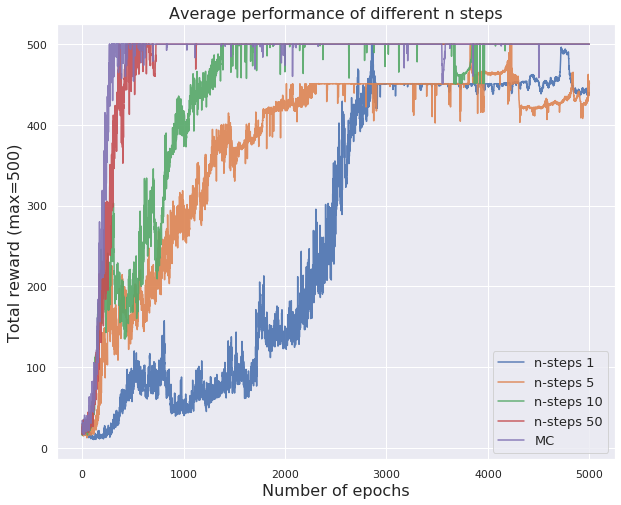

In [10]:
plt.figure(figsize=(10,8))
n_epochs = np.arange(HP_scores_b.shape[2])
for i in range(len(HP_scores_b)):
    if list_of_dict_b[i]['TD'] == True:
        label = "n-steps %d"%list_of_dict_b[i]['n_steps']
    else:
        label = "MC"
    average = HP_scores_b[i].mean(axis=0)
    plt.plot(n_epochs, average, alpha=0.9, label=label)
plt.title("Average performance of different n steps", fontsize=16)
plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Total reward (max=500)", fontsize=16)
plt.legend(fontsize = 13)                                                        
plt.show()

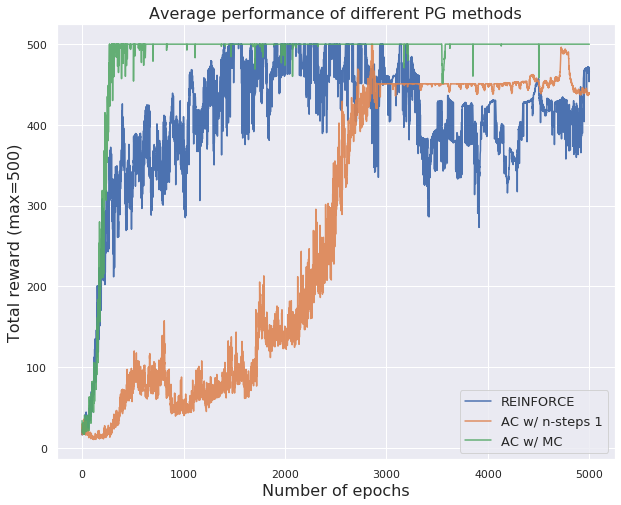

In [11]:
plt.figure(figsize=(10,8))
n_epochs = np.arange(HP_scores_b.shape[2])
plt.plot(n_epochs, REINFORCE_results.mean(axis=0), label='REINFORCE')
plt.plot(n_epochs, HP_scores_b[0].mean(axis=0), alpha=0.9, label='AC w/ n-steps 1')
plt.plot(n_epochs, HP_scores_b[-1].mean(axis=0), alpha=0.9, label='AC w/ MC')
plt.title("Average performance of different PG methods", fontsize=16)
plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Total reward (max=500)", fontsize=16)
plt.legend(fontsize = 13)                                                        
plt.show()

In [6]:
def plot_moving_average(x, y, average_window=20, **kwargs):
    X = x[:-average_window]
    Y = np.array([y[i:i+average_window].mean() for i in range(len(y)-average_window)])
    p = plt.plot(X, Y, **kwargs)
    return p

In [7]:
def plot_n_runs(x, y, label):
    """
    x.shape = (n_epochs,)
    y.shape = (n_runs, n_epochs)
    """
    average = y.mean(axis=0)
    p = plot_moving_average(x, average, alpha=0.9, label=label)
    c = p[-1].get_color()
    for b in range(y.shape[0]):
        plot_moving_average(x, y[b], alpha=0.1, c=c)

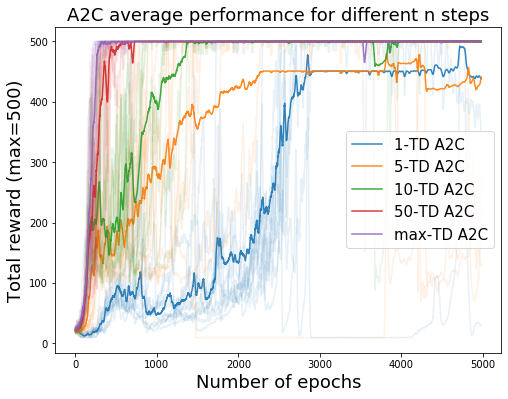

In [10]:
plt.figure(figsize=(8,6))
n_epochs = np.arange(HP_scores_b.shape[2])
for i in range(len(HP_scores_b)):
    if list_of_dict_b[i]['TD'] == True:
        label = "%d-TD A2C"%list_of_dict_b[i]['n_steps']
    else:
        label = "max-TD A2C"
    plot_n_runs(n_epochs, HP_scores_b[i], label=label)
plt.title("A2C average performance for different n steps", fontsize=18)
plt.xlabel("Number of epochs", fontsize=18)
plt.ylabel("Total reward (max=500)", fontsize=18)
plt.legend(fontsize = 15)                                                        
plt.show()

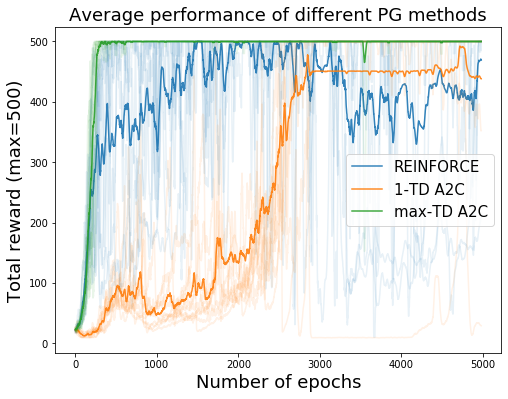

In [9]:
plt.figure(figsize=(8,6))
n_epochs = np.arange(HP_scores_b.shape[2])
plot_n_runs(n_epochs, REINFORCE_results, label='REINFORCE')
plot_n_runs(n_epochs, HP_scores_b[0], label='1-TD A2C')
plot_n_runs(n_epochs, HP_scores_b[-1], label='max-TD A2C')
plt.title("Average performance of different PG methods", fontsize=18)
plt.xlabel("Number of epochs", fontsize=18)
plt.ylabel("Total reward (max=500)", fontsize=18)
plt.legend(fontsize = 15)                                                        
plt.show()